## NEON HSI tutorial on kmeans and PCA changed to use TileDB

https://www.neonscience.org/resources/learning-hub/tutorials/classification-kmeans-pca-python

Please download the dataset to your data folder at the top level of project.

We will import the required modules

In [2]:
from spectral import kmeans, imshow, principal_components
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.windows import Window
import tiledb

array_uri = 'arrays/hsi_output'

We will create the array, note how we order the band dimension to be first

In [2]:
!gdal_translate -OF TileDB -CO BLOCKXSIZE=1024 -CO BLOCKYSIZE=1024 -CO INTERLEAVE=BAND ../data/SERC_hyperspectral_ENVI_format/NEON_D02_SERC_DP3_368000_4306000_reflectance.dat arrays/hsi_output

ERROR 4: ../data/ERC_hyperspectral_ENVI_format/NEON_D02_SERC_DP3_368000_4306000_reflectance.dat: No such file or directory


We will then check the array schema, note that there are 426 bands (hyperspectral)

In [3]:
with tiledb.open(array_uri) as arr:
    print(arr.schema)

ArraySchema(
  domain=Domain(*[
    Dim(name='BANDS', domain=(1, 426), tile='1', dtype='uint64'),
    Dim(name='Y', domain=(0, 999), tile='1000', dtype='uint64'),
    Dim(name='X', domain=(0, 999), tile='1000', dtype='uint64'),
  ]),
  attrs=[
    Attr(name='TDB_VALUES', dtype='int16', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=7)]),
)



And we will extract the visible (R, G ,B) bands and view them in a plot. Note that we are are retrieving these bands from a TileDB array in cloud storage within AWS.

In [4]:
with rasterio.open(array_uri) as src:
    print(src.meta)
    print('First 3 Band Center Wavelengths:', src.tags(1), src.tags(2), src.tags(3))
    data = reshape_as_image(src.read((59, 35, 20)))

{'driver': 'TileDB', 'dtype': 'int16', 'nodata': -9999.0, 'width': 1000, 'height': 1000, 'count': 426, 'crs': CRS.from_epsg(32618), 'transform': Affine(1.0, -0.0, 368000.0,
       -0.0, -1.0, 4307000.0)}
First 3 Band Center Wavelengths: {'wavelength': '383.534302', 'wavelength_units': 'nanometers'} {'wavelength': '388.542206', 'wavelength_units': 'nanometers'} {'wavelength': '393.550110', 'wavelength_units': 'nanometers'}


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [58.0, 1471.0]
    G: [184.0, 1330.0]
    B: [86.0, 1099.0]



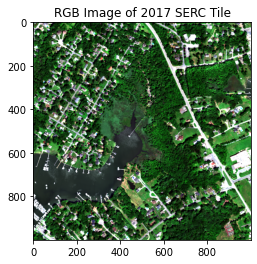

In [5]:
view = imshow(data, stretch=0.05, title='RGB Image of 2017 SERC Tile')
print(view)

We will pick the valid bands (i.e. remove water vapor) and we will do this with TileDB to show the optimized retrieval of both the bands and the area of interest

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [127.0, 450.0]
    G: [301.0, 753.0]
    B: [115.0, 391.0]



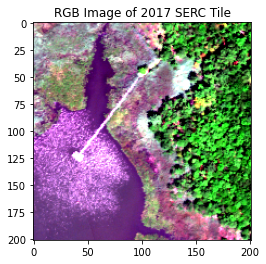

In [6]:
valid_band_range = [(1, 191), (213, 281), (316, 415)] # remove water vapor bands

with tiledb.open(array_uri) as arr:
    img_subset = reshape_as_image(arr.multi_index[valid_band_range, (400, 600), (400, 600)]['TDB_VALUES'])
    view = imshow(np.dstack([img_subset[:, :, 59], img_subset[:, :, 35], img_subset[:, :, 20]]), stretch=0.05, title='RGB Image of 2017 SERC Tile')
    print(view)

And now we will perform the unsupervised (kmeans) classification

In [7]:
(m, c) = kmeans(img_subset,5,50) 

spectral:INFO: k-means iteration 1 - 27560 pixels reassigned.
spectral:INFO: k-means iteration 2 - 4028 pixels reassigned.
spectral:INFO: k-means iteration 3 - 1712 pixels reassigned.
spectral:INFO: k-means iteration 4 - 1156 pixels reassigned.
spectral:INFO: k-means iteration 5 - 826 pixels reassigned.
spectral:INFO: k-means iteration 6 - 448 pixels reassigned.
spectral:INFO: k-means iteration 7 - 246 pixels reassigned.
spectral:INFO: k-means iteration 8 - 141 pixels reassigned.
spectral:INFO: k-means iteration 9 - 90 pixels reassigned.
spectral:INFO: k-means iteration 10 - 43 pixels reassigned.
spectral:INFO: k-means iteration 11 - 18 pixels reassigned.
spectral:INFO: k-means iteration 12 - 4 pixels reassigned.
spectral:INFO: k-means iteration 13 - 2 pixels reassigned.
spectral:INFO: k-means iteration 14 - 1 pixels reassigned.
spectral:INFO: k-means iteration 15 - 1 pixels reassigned.
spectral:INFO: k-means iteration 16 - 1 pixels reassigned.
spectral:INFO: k-means iteration 17 - 0 p

In [8]:
print(c.shape)

(5, 360)


c contains 5 groups of spectral curves with 360 bands (the # of bands we've kept after removing the water vapor windows and the last 10 noisy bands). Let's plot these spectral classes:

Text(0, 0.5, 'Reflectance')

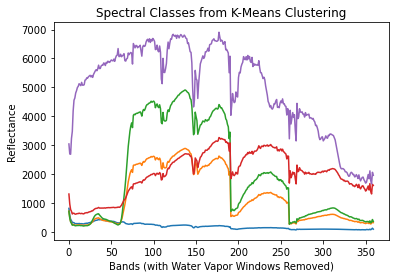

In [9]:
%matplotlib inline
import pylab
pylab.figure()
for i in range(c.shape[0]):
    pylab.plot(c[i])
pylab.show
pylab.title('Spectral Classes from K-Means Clustering')
pylab.xlabel('Bands (with Water Vapor Windows Removed)')
pylab.ylabel('Reflectance')

/opt/conda/lib/python3.7/site-packages/spectral/graphics/spypylab.py:904: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (59, 35, 20)
  Interpolation       :  <default>
  RGB data limits     :
    R: [77.0, 619.0]
    G: [184.0, 904.0]
    B: [82.0, 502.0]
>

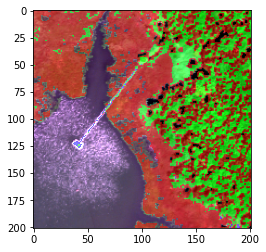

In [10]:
#%matplotlib notebook
view = imshow(img_subset, bands=(59, 35, 20), stretch=0.01, classes=m)
view.set_display_mode('overlay')
view.class_alpha = 0.5 #set transparency
view.show_data

## Principal Component Analysis (PCA)

Many of the bands within hyperspectral images are often strongly correlated. The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands) .

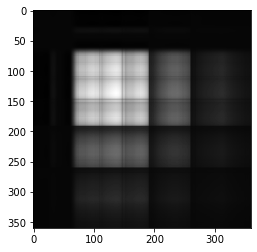

In [11]:
pc = principal_components(img_subset)
pc_view = imshow(pc.cov)
xdata = pc.transform(img_subset)

In [12]:
pcdata = pc.reduce(num=10).transform(img_subset)

5
(201, 201, 5)


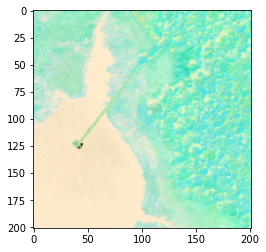

In [13]:
pc_0999 = pc.reduce(fraction=0.999)

# How many eigenvalues are left?
print(len(pc_0999.eigenvalues))

img_pc = pc_0999.transform(img_subset)
print(img_pc.shape)

v = imshow(img_pc[:,:,:5], stretch_all=True)